# Variational Logistic Regression

This notebook shows how to implement the variational logistic regression model according to the derivation in PRML.

Application of the model is demonstrated using the same linearly separable clusters of Gaussian distrbutions points.

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt

np.random.seed(seed=0)

# Data

Linearly separable dataset consisting of datapoints generated from two Gaussian distributions.

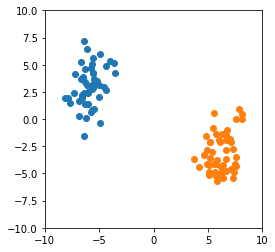

In [2]:
mean_1 = [-6, 3]
cov_1 = [[1,0.5],[0.5,3]]
gaussian_1 = np.random.multivariate_normal(mean_1, cov_1, 50)

mean_2 = [6, -3]
cov_2 = [[1,0.5],[0.5,3]]
gaussian_2 = np.random.multivariate_normal(mean_2, cov_2, 50)

plt.scatter(gaussian_1[:,0], gaussian_1[:,1])
plt.scatter(gaussian_2[:,0], gaussian_2[:,1])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Sort data into labeled dataset

The dataset is represented as an (N,2) array with each row $n$ corresponding to input variable vector $x^{(n)} = (x^{(n)}_1, x^{(n)}_2)$.

<table style="border:1">
    <tr>
        <td>$x^{(1)}_1$</td>
        <td>$x^{(1)}_2$</td>
    </tr>
    <tr>
        <td>$x^{(2)}_1$</td>
        <td>$x^{(2)}_2$</td>
    </tr>
        <tr>
        <td>$\dots$</td>
        <td>$\dots$</td>
    </tr>
    <tr>
        <td>$x^{(N)}_1$</td>
        <td>$x^{(N)}_2$</td>
    </tr>
</table>

In [3]:
data_1 = np.zeros((gaussian_1.shape[0], 3))
data_1[:,0:2] = gaussian_1

data_2 = np.ones((gaussian_2.shape[0], 3))
data_2[:,0:2] = gaussian_2

In [4]:
# Dataset is stored as a (N,2) array
dataset = np.vstack((data_1, data_2))
dataset = np.random.permutation(dataset)

# Number of samples
N = dataset.shape[0]

### Linear basis function model

Applying a fixed nonlinear transformation on the input variable vectors $x$ to generate feature vectors $\phi$, allowing the model to consider linear combinations of fixed nonlinear functions of the input variables.

$\phi^{(n)} = (\phi_1(x^{(n)}), \dots, \phi_N(x^{(n)})), \:\:\: where \: \phi_j = f(x)$

The dataset features are represented as an (I,N) array with with each column $n$ corresponding to a feature vector $\phi^{(n)}$.

<table style="border:1">
    <tr>
        <td>$\phi^{(1)}_1$</td>
        <td>$\phi^{(2)}_1$</td>
        <td>$\dots$</td>
        <td>$\phi^{(N)}_1$</td>
    </tr>
    <tr>
        <td>$\phi^{(1)}_2$</td>
        <td>$\phi^{(2)}_2$</td>
        <td>$\dots$</td>
        <td>$\phi^{(N)}_2$</td>
    </tr>
    <tr>
        <td>$\dots$</td>
        <td>$\dots$</td>
        <td>$\dots$</td>
        <td>$\dots$</td>
    </tr>
    <tr>
        <td>$\phi^{(1)}_I$</td>
        <td>$\phi^{(2)}_I$</td>
        <td>$\dots$</td>
        <td>$\phi^{(N)}_I$</td>
    </tr>
</table>

In [5]:
def input2feature(input_vec, normalization_const=5.0):
    '''
    Args:
        input_vec: Input vector of shape (1,2)
        
    Returns:
        feat_vec: Feature vector of shape(6,1)
    '''
    
    input_vec = np.array(input_vec) / normalization_const
    
    feat_vec = np.zeros((6,1))
    
    feat_vec[0,0] = input_vec[0]
    feat_vec[1,0] = input_vec[0]**2
    feat_vec[2,0] = input_vec[1]
    feat_vec[3,0] = input_vec[1]**2
    feat_vec[4,0] = input_vec[0] * input_vec[1]
    feat_vec[5,0] = 1.0
    
    return feat_vec

In [6]:
phis = np.zeros((6, N))

for n in range(N):
    phis[:,n:n+1] =input2feature(dataset[n,:])

# Number of features
D = phis.shape[0]

ts = np.zeros((1,N))
ts[0,:] = dataset[:,2]

### Labels

Stored as an (1,N) array with each column $n$ corresponding to label $t$ of example $n$.

<table style="border:1">
    <tr>
        <td>$t^{(1)}$</td>
        <td>$t^{(2)}$</td>
        <td>$\dots$</td>
        <td>$t^{(N)}$</td>
    </tr>
</table>

### Summary of data

In [7]:
print(f"Feature array 'phis' : {phis.shape}")
print(f"Label array 'ts'     : {ts.shape}")
print(f"    #Samples  : {D}")
print(f"    #Features : {D}")

Feature array 'phis' : (6, 100)
Label array 'ts'     : (1, 100)
    #Samples  : 6
    #Features : 6


# What is this local variational inference functional again?

In [8]:
def lambda_func(xi):
    return (expit(xi) - 0.5) / (2*xi + 1e-24)

# Expectations

In [9]:
def gamma_expectation(a_N, b_N):
    '''Returns the expected value of a Gamma distribution defined by parameters 'a_N' and 'b_N'.
    
    Ref: Bishop Eq 10.182 (p.505)
    '''
    return a_N / b_N


def gaussian_quadratic_expectation_wrt_w(mu_N):
    '''Returns the expected value of the quadratic weight vectors for a Gaussian distribution w.r.t. weights.
    
    Because we are taking the expectations w.r.t. weights, other unrelated terms can be dropped from the general expectation.
    
    Ref: Bishop Eq 10.183 (p.505)
    '''
    return np.matmul(mu_N.T, mu_N)

# Maximization (re-estimation) equations

In [10]:
#######################################################
#  Distribution 'q(w) = Gaussian(w | mu_N, sigma_N)'
#######################################################

def maximization_mu(phis, ts, sigma_N):
    '''Maximizes the weight vector distribution 'q(w)' w.r.t. mean vector.
    
    Args:
        phis:   : Feature matrix of shape (D,N)
        ts      : Label vector of shape (1,N)
        sigma_N : Covariance matrix for 'q(w)' of shape (D,D)
    
    Returns:
        mu_N : Vector of shape (D,1)
    
    Ref: Bishop Eq 10.175 (p.504)
    '''
    
    # Vector container for summing individual samples
    sample_vec_sum = np.zeros((phis.shape[0], 1))
    
    # Compute and sum each sample individually (TODO: vectorization)
    for i in range(phis.shape[1]):
        
        # Vectors for sample 'i'
        phi_i = phis[:,i:i+1]  # [D,1]
        t_i = ts[:,i].item()   # scalar
        
        sample_vec_sum += (t_i - 0.5) * phi_i
    
    mu_N = np.matmul(sigma_N, sample_vec_sum)
    
    return mu_N


def maximization_sigma_inv(expectation_alpha, xis, phis):
    '''Maximizes the weight vector distribution 'q(w)' w.r.t. variance of data.
    
    Args:
        expectation_alpha : Expected value of Gamma distribution modeling variance of 'q(w)'.
        xis               : Variational variable related to the class certainty of a sample (I think).
        phis              : Feature matrix of shape (D,N).
        
    Returns:
        sigma_inv : Precision of q(w) which optimizes the approximation.
    
    Ref: Bishop Eq 10.176 (p.504)
    '''
    
    # Vector container for summing individual samples
    sample_vec_sum = np.zeros((D,D))
    
    # Compute and sum each sample individually (TODO: vectorization)
    for i in range(phis.shape[1]):
        
        # Vectors for sample 'i'
        phi_i = phis[:,i:i+1]   # [D,1]
        xi_i = xis[:,i].item()  # scalar
        
        sample_vec_sum += lambda_func(xi_i) * np.matmul(phi_i, phi_i.T)
        
    sigma_inv = expectation_alpha * np.eye(D) + 2.0 * sample_vec_sum

    return sigma_inv


####################################################
#  Distribution 'q(alpha) = Gam(alpha | a_N, b_N)  #
####################################################

def maximization_an(a_0, D):
    '''Maximizes the covariance matrix 'q(alpha)' w.r.t. the 'a_N' parameter.
    
    Args:
        a_0 : Value of initial variational hyperpriors.
        D   : Number of features.
    '''
    return a_0 + D


def maximization_bn(b_0, expectation_quadratic_w):
    '''Maximizes the covariance matrix 'q(alpha)' w.r.t. the 'a_N' parameter.
    
    Args:
        b_0                     : Value of initial variational hyperpriors.
        expectation_quadratic_w : The expected value of the quadratic weight vectors for a Gaussian distribution w.r.t. weights.
    '''
    return b_0 + 0.5 * expectation_quadratic_w


###############
#  Xi update
###############

def xi_update(phi, mu_N, sigma_N):
    '''Computes the optimal variational variable related to class certainity (I think) of one sample, according to weight distribution 'q(w)'.
    
    Args:
        phi     : Sample feature vector of shape (D,1)
        mu_N    : Mean vector for weight distribution 'q(w)' of shape (D,1)
        sigma_N : Covariance matrix for weight distribution 'q(w)'  of shape (D,D)
    
    Returns : 'xi' value for one sample given 'q(w)'
    '''
    # xi = phi.T * (sigma_N + mu_N * mu_N.T) * phi
    A = sigma_N + np.matmul(mu_N, mu_N.T)
    xi = np.matmul(np.matmul(phi.T, A), phi)
    xi = np.sqrt(xi)
    return xi


def xis_update(phis, mu_N, sigma_N):
    '''Computes the optimal variational variable related to class certainity (I think) of all samples.
    
    Args:
        phi     : Sample feature matrix of shape (D,N)
        mu_N    : Mean vector for weight distribution 'q(w)' of shape (D,1)
        sigma_N : Covariance matrix for weight distribution 'q(w)' of shape (D,D)
    '''
    N = phis.shape[1]
    
    # Vector container for storing updated 'xi' values
    xis_new = np.zeros((1,N))
    
    # Compute each sample individually
    for i in range(N):
        
        # Vector for sample 'i'
        phi_i = phis[:,i:i+1]   # [D,1]
        
        xis_new[0,i] = xi_update(phi_i, mu_N, sigma_N)
    
    return xis_new

# Expectation Maximization iteration

All variational variables $\xi$ and parameters $\mu_N$. $\Sigma_N$, as well as the variatioanl hyperpriors $a_0$, $b_0$, are first initialized with some random value.

The EM algorithm is implemented to infer the optimal distributional parameters for $q(w)$ and $q(\alpha)$ which maximizes the approximation of the joint distribution $p(t, x, w)$ where $(t, x)$ denotes the data.

_Expectation step:_

Given the current "best estimation" of the distributions $q(w)$ and $q(\alpha)$, compute expectations for variables according to the distributions.

_Maximization step:_

Given the expectations computed in the previous step, re-optimize the parameters for the same distributions, as well as the variational variable $\xi$.

In [11]:
def comp_lower_bound(sigma_0, sigma_N, sigma_N_inv, mu_N, xis):
    
    sigma_N_det = np.linalg.det(sigma_N)
    sigma_0_det = np.linalg.det(sigma_0)
    
    term_1 = 0.5 * np.log(sigma_N_det / sigma_0_det)
    
    term_2 = 0.5 * np.matmul(mu_N.T, np.matmul(sigma_N_inv, mu_N)).item()
    
    term_3 = 0.0  # As mu_0 = zero vector
    
    term_4 = 0.

    for idx in range(xis.shape[1]):
        
        xi = xis[0,idx]
        term_4 += np.log(expit(xi)) - 0.5*xi - lambda_func(xi) * xi**2 
    
    return term_1 - term_2 + term_3 + term_4

In [12]:
#######################
#  Initial variables
#######################

# Hyperpriors for Gamma distribution
a_0 = 1.0
b_0 = 1.0

a_N = a_0
b_N = b_0

mu_N = np.random.random((D,1))
sigma_N = np.random.random((D,D))

# Sample-specific latent variables 'xi'
xis = np.ones((1, N))

for iter_idx in range(1,501):
    
    # Expectation step
    expectation_alpha = gamma_expectation(a_N, b_N)                             # scalar
    expectation_quadratic_w_wrt_w = gaussian_quadratic_expectation_wrt_w(mu_N)  # scalar
    
    # Maximization step
    a_N = maximization_an(a_0, D)                                               # scalar
    b_N = maximization_bn(b_0, expectation_quadratic_w_wrt_w)                   # scalar
    sigma_N_inv = maximization_sigma_inv(expectation_alpha, xis, phis)          # [D,D]
    sigma_N = np.linalg.inv(sigma_N_inv)                                        # [D,D]
    mu_N = maximization_mu(phis, ts, sigma_N)                                   # [D,1]
    xis = xis_update(phis, mu_N, sigma_N)                                       # [1,N]
    
    # Compute lower bound
    sigma_0 = expectation_alpha * np.eye(D)
    if iter_idx % 10 == 0:
        print(f"iter {iter_idx} | {-comp_lower_bound(sigma_0, sigma_N, sigma_N_inv, mu_N, xis)}")

iter 10 | 344.9450515828182
iter 20 | 368.5916259992124
iter 30 | 374.1396614291902
iter 40 | 375.536975941974
iter 50 | 375.8948885009498
iter 60 | 375.9869592921439
iter 70 | 376.01067025093306
iter 80 | 376.0167782996393
iter 90 | 376.01835188093816
iter 100 | 376.01875728192493
iter 110 | 376.0188617257719
iter 120 | 376.01888863378275
iter 130 | 376.0188955661333
iter 140 | 376.01889735212507
iter 150 | 376.01889781225276
iter 160 | 376.0188979307969
iter 170 | 376.01889796133725
iter 180 | 376.0188979692051
iter 190 | 376.0188979712319
iter 200 | 376.0188979717546
iter 210 | 376.0188979718893
iter 220 | 376.0188979719239
iter 230 | 376.01889797193303
iter 240 | 376.01889797193536
iter 250 | 376.0188979719362
iter 260 | 376.0188979719365
iter 270 | 376.01889797193627
iter 280 | 376.01889797193616
iter 290 | 376.0188979719365
iter 300 | 376.01889797193616
iter 310 | 376.0188979719364
iter 320 | 376.0188979719362
iter 330 | 376.0188979719363
iter 340 | 376.0188979719363
iter 350 | 3

### Computing the predictive posterior $p(t^{new} | \phi^{new}, \theta)$



In [13]:
def predictive_posterior_prob(x, mu_n, sigma_N):
    '''Computes the probability of a new input vector 'x' belonging to class 1 using the learned variational parameters.
    
    Args:
        x       : Input vector (or list) of shape (1,2)
        mu_n    : Learned mean vector for weight distribution 'q(w)'
        sigma_N : Learned covariance matrix for weight distribution 'q(w)'
        
    Ref: Bishop Eq 4.155 (p.220)
    '''
    phi_new =input2feature(x)

    mu_a = np.matmul(mu_N.T, phi_new).item()
    sigma_a_2 = np.matmul(np.matmul(phi_new.T, sigma_N), phi_new).item()

    kappa = np.power(1.0 + np.pi/8.0 * sigma_a_2,-0.5)

    p = expit(kappa*mu_a)
    
    return p

In [14]:
# Compute posterior class probability over the whole input space.

x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)

xx, yy = np.meshgrid(x, y, sparse=False)

p_array = np.zeros(xx.shape)

for i in range(p_array.shape[0]):
    for j in range(p_array.shape[1]):
        
        x = [xx[i,j], yy[i,j]]
        
        p_array[i,j] = predictive_posterior_prob(x, mu_N, sigma_N)

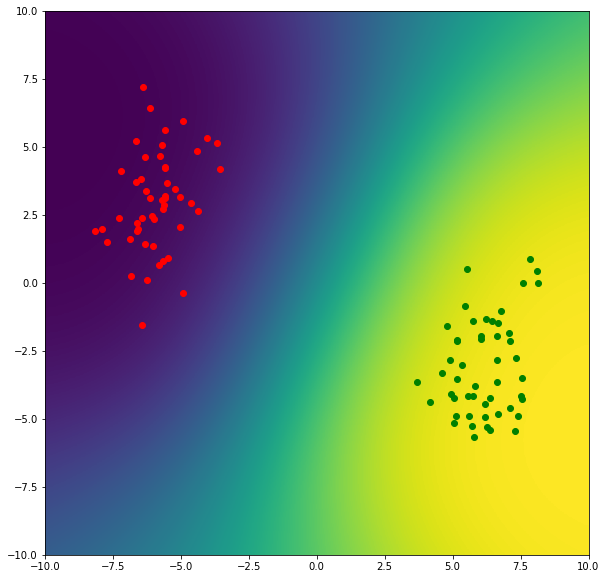

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(p_array, origin='lower', extent=[-10,10,-10,10])
plt.scatter(gaussian_1[:,0], gaussian_1[:,1], c='r')
plt.scatter(gaussian_2[:,0], gaussian_2[:,1], c='g')

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()